In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/weather1_education_train.csv', parse_dates=['timestamp'])
train.columns

Index(['Unnamed: 0', 'area', 'building_name', 'electricity',
       'primary_space_usage', 'timestamp', 'TemperatureC', 'month', 'year',
       'date', 'hour', 'weekday', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'date_1', 'date_2', 'date_3', 'date_4',
       'date_5', 'date_6', 'date_7', 'date_8', 'date_9', 'date_10', 'date_11',
       'date_12', 'date_13', 'date_14', 'date_15', 'date_16', 'date_17',
       'date_18', 'date_19', 'date_20', 'date_21', 'date_22', 'date_23',
       'date_24', 'date_25', 'date_26', 'date_27', 'date_28', 'date_29',
       'date_30', 'date_31', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'wkday_0', 'wkday_1', 'wkday_2'

In [3]:
test = pd.read_csv('../data/weather1_education_test.csv', parse_dates=['timestamp'])

In [4]:
def naive_model(df, profile, num_buildings, start_day, fit_len):
    '''
    profile is a list of features used to calculate hourly avg
    for example, profile = ['primary_space_usage']
    start_day is the day of the week
    fit_len is the number of hourly observations used to take avg
    '''
    one_year = 8760
    profile.append('hour')
    profile.append('weekday')
    df = df.groupby('building_name').head(fit_len)
    hourly_avg = df.groupby(profile).mean()['electricity'].round(1).unstack()#take avg
    hourly_avg = hourly_avg.droplevel(-1)
    ite_index = hourly_avg.index.unique()
    y_pred = pd.DataFrame(columns=ite_index)
    #make 1 day data for each group
    for idx in ite_index:
        y_temp = np.array(hourly_avg.loc[idx]).T.reshape(168,)
        y_pred [idx] = y_temp
    #make 1 year data for eac group
    for _ in range(6):
        y_pred = pd.concat([y_pred, y_pred], axis=0, ignore_index=True)
    y_pred = y_pred.iloc[start_day:start_day+one_year]
    profile.remove('hour')
    profile.remove('weekday')
    df_profile = (df.groupby('building_name').first())[profile]
    res = pd.DataFrame()
    #put appropreate prediction to each building
    for i in range(len(df_profile)):
        key = df_profile.iloc[i].values
        if len(key) > 1:
            key = tuple(key)
        res = pd.concat([res, y_pred[key]], axis=1)
    y_true = np.array(df['electricity']).reshape((num_buildings, len(df)//num_buildings))
    return y_true, np.array(res.transpose())

In [5]:
y, y_pred = naive_model(train, ['primary_space_usage'], 50, 0, 24*90)
display(y)
display(y_pred)

array([[34.900002  , 32.7       , 32.2       , ..., 47.899999  ,
        48.900002  , 46.        ],
       [ 5.        ,  5.1999998 ,  5.1999998 , ...,  5.8       ,
         5.7000001 ,  2.95714296],
       [ 4.        ,  3.9       ,  3.5       , ...,  4.7000001 ,
         3.7       ,  1.9632653 ],
       ...,
       [45.3       , 42.399999  , 42.5       , ..., 33.800001  ,
        34.200001  , 37.700001  ],
       [25.2       , 26.2       , 25.4       , ..., 25.2       ,
        24.2       , 24.4       ],
       [28.4       , 27.        , 26.7       , ..., 37.9       ,
        37.4       , 35.399999  ]])

array([[12.2, 11.8, 11.8, ..., 13. , 12. , 12.1],
       [12.2, 11.8, 11.8, ..., 13. , 12. , 12.1],
       [12.2, 11.8, 11.8, ..., 13. , 12. , 12.1],
       ...,
       [12.2, 11.8, 11.8, ..., 13. , 12. , 12.1],
       [12.2, 11.8, 11.8, ..., 13. , 12. , 12.1],
       [28.9, 28.5, 28.1, ..., 31.5, 30.8, 30.3]])

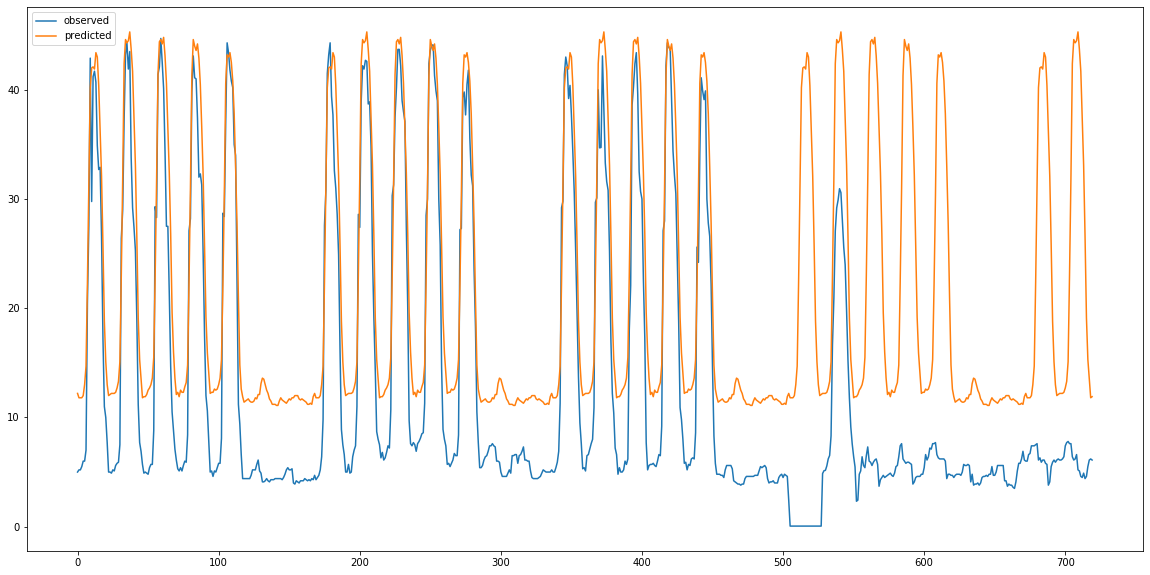

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(y[1][:24*30], label='observed')
plt.plot(y_pred[1][:24*30], label='predicted')
plt.legend();

In [7]:
def same_shape(y, y_pred):
    n = min(y.shape[1], y_pred.shape[1])
    return y[:n], y_pred[:,:n]

In [8]:
y, y_pred = same_shape(y, y_pred)

In [9]:
MSE = np.mean(np.square(y-y_pred))
MSE

950.0735081979079

In [10]:
MAE = np.mean(np.abs(y-y_pred))
MAE

18.002158306110154